In [1]:
#!conda install -c blaze sqlite3

In [2]:
import sqlite3
import pandas as pd

#### Import the dataset here just for one forest type (Douglass fir) and one site class (3)

In [3]:

cnx = sqlite3.connect('db_example_FVSCompute_WS001Thinx0.db')
sql = 'select * from FVS_COMPUTE where forest_type = "DF" and si_class = 3'
data = pd.read_sql_query(sql, cnx)

In [4]:
len(data.standid.unique()) ## The number of stands in the forest

145

In [5]:
# Compute the mean annual increment on the cubic foot column
data['mai'] = data['cf08'] / data['ageef']

In [6]:
data.head(2)

,caseid,standid,year,si_class,forest_type,ageef,topht,mbf08,cf08,cf,mai
0,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2015,3,DF,19.7835,43.0120,0.25571,57.114,452.904,2.886951
1,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2025,3,DF,29.7835,63.2978,4.63026,1215.620,1772.530,40.815216


#### The conversion factor from cubic feet to cubic meters

In [7]:
cf_to_cm = 0.0283168  # converstion factor

In [8]:
data['vol_cm'] = data['cf08'] * cf_to_cm # volume in cubic meters

In [9]:
data.head(2)

,caseid,standid,year,si_class,forest_type,ageef,topht,mbf08,cf08,cf,mai,vol_cm
0,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2015,3,DF,19.7835,43.0120,0.25571,57.114,452.904,2.886951,1.617286
1,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2025,3,DF,29.7835,63.2978,4.63026,1215.620,1772.530,40.815216,34.422468


In [10]:
data['mai_cm'] = data['vol_cm'] / data['ageef'] # mai in cubic meters

In [11]:
data.head(2)

,caseid,standid,year,si_class,forest_type,ageef,topht,mbf08,cf08,cf,mai,vol_cm,mai_cm
0,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2015,3,DF,19.7835,43.0120,0.25571,57.114,452.904,2.886951,1.617286,0.081749
1,024c8607-6621-4998-a1f5-3c20e1a0377b,56d2cf63-0be3-4b54-9ac9-9a,2025,3,DF,29.7835,63.2978,4.63026,1215.620,1772.530,40.815216,34.422468,1.155756


#### The list of stands

In [12]:
unique_standid = data.standid.unique()

In [13]:
data_interest = data[['standid', 'year', 'ageef', 'vol_cm', 'mai_cm']] # Just keep the columns we need

In [22]:
def compute_mai_for_single_scenario(max_scen = 1.6, data = data_interest, unique_standid = unique_standid):
    """ Computes mai for the a given climate scenario.
        Param 
        ------------
        max_scen: <i>float</i> is the float corresponding to the maximum mean annual increment as 
                    given in Latta's equations
        data: <i>pandas dataframe</i> dataframe containing the standid, the mean annual increment in cubic meters
        unique_standid = <i>list</i> is the list of different stands available in the database
        
        returns
        ---------------
        d : <i>dataframe</i> that is a copy of the original data plus a column with the mean annual increment 
            computed under climate scenario. For now it is hard wired to be called <b> mai_A1B</b>
                
    """
    d = None
    for j in range(len(unique_standid)):
        c = data_interest[data_interest.standid == unique_standid[j]]
        idx_max = c['mai_cm'].idxmax()
        increment = max_scen / max(1, list(c.index).index(idx_max))
        position = 0
        for i in c.index:

            if i <= idx_max:
                c.loc[i,'mai_A1B'] = float(c.loc[i, 'mai_cm']  + position * increment)
            else:
                c.loc[i,'mai_A1B'] = float(c.loc[i, 'mai_cm'] * (c.loc[idx_max, 'mai_cm'] + max_scen)) / float(c.loc[idx_max, 'mai_cm'])
            position += 1
        frame = [d,c]
        d = pd.concat(frame)
    return d

In [23]:
d = compute_mai_for_single_scenario(max_scen = 1.6)

C:\Users\Martins\Anaconda3\envs\viz3d\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Martins\Anaconda3\envs\viz3d\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
d.head(20)

,standid,year,ageef,vol_cm,mai_cm,mai_A1B
0,56d2cf63-0be3-4b54-9ac9-9a,2015,19.7835,1.617286,0.081749,0.081749
1,56d2cf63-0be3-4b54-9ac9-9a,2025,29.7835,34.422468,1.155756,1.422423
2,56d2cf63-0be3-4b54-9ac9-9a,2035,39.7835,89.053221,2.238446,2.771779
3,56d2cf63-0be3-4b54-9ac9-9a,2045,49.7835,158.473272,3.183249,3.983249
4,56d2cf63-0be3-4b54-9ac9-9a,2055,59.7835,225.439956,3.770939,4.837606
5,56d2cf63-0be3-4b54-9ac9-9a,2065,69.7835,285.048236,4.084751,5.418085
6,56d2cf63-0be3-4b54-9ac9-9a,2075,79.7835,331.289570,4.152357,5.752357
7,56d2cf63-0be3-4b54-9ac9-9a,2085,89.7835,363.698148,4.050835,5.611716
8,56d2cf63-0be3-4b54-9ac9-9a,2095,99.7835,382.718542,3.835489,5.313393
9,56d2cf63-0be3-4b54-9ac9-9a,2105,109.7840,401.302858,3.655386,5.063891


#### Plot a comparison of MAI from the current FVS volume projection and the MAI from Scenario A1B

In [18]:
%matplotlib notebook

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


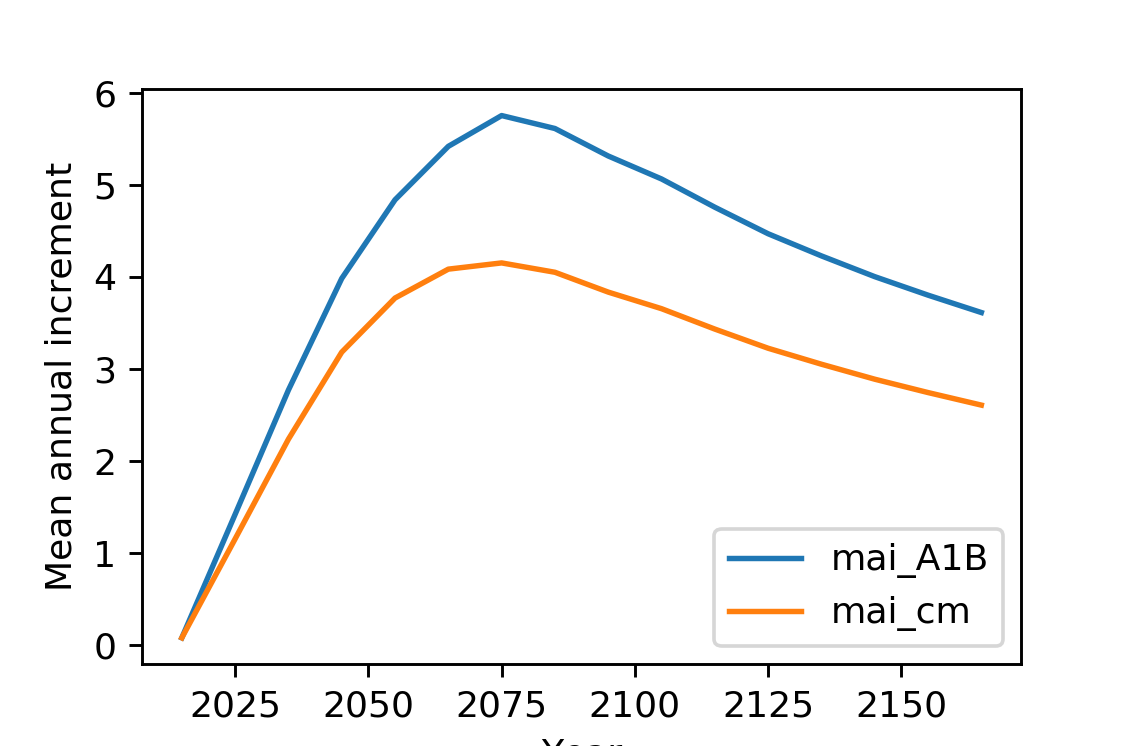

In [24]:
subset = 0 # unique can be changed so that we have different stands
y1 = d[d.standid == d.standid.unique()[subset]]['mai_A1B']
y2 = d[d.standid == d.standid.unique()[subset]]['mai_cm']
x = d[d.standid == d.standid.unique()[subset]]['year']
plt.plot(x, y1)
plt.plot(x, y2)
plt.xlabel('Year')
plt.ylabel('Mean annual increment')
plt.legend()
plt.show()

#### Compute the volume corresponding to the climate scenario

In [20]:
d['vol_A1B'] = d['mai_A1B'] * d['ageef']

In [21]:
d.head()

,standid,year,ageef,vol_cm,mai_cm,mai_A1B,vol_A1B
0,56d2cf63-0be3-4b54-9ac9-9a,2015,19.7835,1.617286,0.081749,0.081749,1.617286
1,56d2cf63-0be3-4b54-9ac9-9a,2025,29.7835,34.422468,1.155756,1.422423,42.364735
2,56d2cf63-0be3-4b54-9ac9-9a,2035,39.7835,89.053221,2.238446,2.771779,110.271088
3,56d2cf63-0be3-4b54-9ac9-9a,2045,49.7835,158.473272,3.183249,3.983249,198.300072
4,56d2cf63-0be3-4b54-9ac9-9a,2055,59.7835,225.439956,3.770939,4.837606,289.209022
